# Recommender System


#### Objectives


The objectives to be achieved with this notebook are as follows:

- Generate several recommenders based on different recommendation algorithms.
- Prepare and convert data for further implementation in Streamlit.

#### Table of contents
           
1. [Import Libraries](#il)
2. [Content Based](#cb)
3. [Most popular Board Games](#pg)
4. [Collaborative Filtering ](#cf)
      - [Matrix Co-Ocurrence](#mco)
      - [Alternating Least Square (ALS) ](#als)

<a id="il"></a>

## 1. Import libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import sys
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import col, explode
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Recall y precision
from reco_utils.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation


print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.9.5 (default, May 18 2021, 12:31:01) 
[Clang 10.0.0 ]
Spark version: 3.1.2


In [2]:
#Load data

path='./DATA'
file = os.path.join(path, "users_bgs.csv")

In [3]:
df=pd.read_csv(file, usecols=['u_id','bgg_id','Game','category','Your Rating'], low_memory=False)
df.head()

,u_id,Game,Your Rating,bgg_id,category
0,0,1830: Railways & Robber Barons,-1,421,"1021,1034,1011"
1,0,18AL,7,2612,"1021,1120,1034,1011"
2,0,2 de Mayo,6,36522,"1051,1019"
3,0,23,7,103651,1002
4,0,6 nimmt!,7,432,"1002,1098"


In [4]:
#Transform explicit values to implicit values
df['Rating'] = df['Your Rating'].apply(lambda x: 1 if x>0 else 0)

#### Remove users who only have one board game

In [5]:
#Group by 'user_id'
p=df.groupby('u_id').count()

In [6]:
# Visualise users with a single board game
(p['bgg_id']==1).sum()

6

In [7]:
# Remove the user_id with a single board game
bgu=list(p[p['bgg_id']==1].index)

dfm = df[~df.u_id.isin(bgu)]

#### Modified the id of games and users so that they are correlative

In [8]:
# Create a dictionary for games titles and ids

bgg_id=list(dfm['bgg_id'])
game=list(dfm['Game'])

item_dict={}

for key in bgg_id:
    for value in game:
        item_dict[key] = value
        game.remove(value)
        break 

In [9]:
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

36535
36535


In [10]:
# Resample
resample_id_item_dict={}
for index, key in enumerate(item_dict.keys()):
    resample_id_item_dict[key]= index
    

In [11]:
resample_item_dict = {resample_id_item_dict[k]:v for k,v in item_dict.items()}
assert(len(set(resample_item_dict.keys())) == len(set(resample_item_dict.values())))

In [12]:
# Create a dictionary for resample users id

u_id=list(dfm['u_id'].unique())
resample_user_dict={}

for index,key in enumerate(u_id):
    resample_user_dict[key] = index

In [13]:
print(len(set(resample_user_dict.keys())))
print(len(set(resample_user_dict.values())))

2844
2844


In [14]:
# Copy and apply the changes
dfm_r=dfm.copy()
dfm_r['item_id']=dfm['bgg_id'].apply(lambda x: resample_id_item_dict[x])
dfm_r['user_id']=dfm['u_id'].apply(lambda x: resample_user_dict[x])
dfm_r.describe()

,u_id,Your Rating,bgg_id,Rating,item_id,user_id
count,838777.000000,838777.000000,838777.000000,838777.000000,838777.000000,838777.000000
mean,1404.570457,3.423040,91310.618300,0.545138,4722.867555,1403.031329
std,813.788285,4.159144,88829.182464,0.497959,6316.864111,812.113149
min,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000
25%,700.000000,-1.000000,9209.000000,0.000000,680.000000,700.000000
50%,1375.000000,5.000000,55952.000000,1.000000,2185.000000,1374.000000
75%,2087.000000,7.000000,163976.000000,1.000000,6332.000000,2086.000000
max,2851.000000,10.000000,332853.000000,1.000000,36534.000000,2843.000000


In [15]:
#dfm_r.to_csv('DATA/r_users_bgs.csv')
#path='./DATA'
#file = os.path.join(path, "r_users_bgs.csv")
#dfm_r=pd.read_csv(file, low_memory=False)
#dfm_r.head()

#### Format Data for models

In [16]:
# DF Ratings

dfratings = pd.DataFrame()

dfratings['user_id']=dfm_r['user_id']
dfratings['item_id']=dfm_r['item_id']
dfratings['rating']=dfm_r['Rating']

print(dfratings.shape)
dfratings.head()

(838777, 3)


,user_id,item_id,rating
0,0,0,0
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [17]:
# Prepare DF BGames

dfbg = dfm_r.groupby(by=['bgg_id','category'], as_index=False).first()
dfbg.drop(['bgg_id','u_id','Your Rating','Rating', 'user_id'],axis=1, inplace=True)

In [18]:
# DF Board Games

dfgames = pd.DataFrame()

dfgames['item_id']=dfbg['item_id']
dfgames['title']=dfbg['Game']
dfgames['category']=dfbg['category']

print(dfgames.shape)
dfgames.head()

(36535, 3)


,item_id,title,category
0,747,Die Macher,"1021,1026,1001"
1,5896,Dragonmaster,"1002,1010"
2,292,Samurai,"1009,1035"
3,6308,Tal der Könige,1050
4,15364,Mare Mediterraneum,"1015,1008"


<a id="cb"></a>

## 2. Content Based

A popular technique in recommender systems is content-based filtering. Content here refers to the attributes of products that a user likes. Thus, the idea in content-based filtering is to tag products with certain keywords, understand what the user likes, search for those keywords in the database, and recommend different products with the same attributes.

This algorithm is intended to create a recommendation system that helps identify games that are similar based on their features. The category of each board game will be used to perform the recommendation system. 


In [19]:
df_games=dfgames.copy()

In [20]:
df_games['category'] = df_games['category'].map(lambda x: x.replace(',', ' '))
print(dfgames['category'])

0        1021,1026,1001
1             1002,1010
2             1009,1035
3                  1050
4             1015,1008
              ...      
36530              1002
36531         1002,1030
36532         1002,2481
36533    1009,1028,1113
36534         1021,1013
Name: category, Length: 36535, dtype: object


In [21]:
df_games.set_index('title', inplace = True)
df_games.head()

,item_id,category
title,,
Die Macher,747,1021 1026 1001
Dragonmaster,5896,1002 1010
Samurai,292,1009 1035
Tal der Könige,6308,1050
Mare Mediterraneum,15364,1015 1008


In [22]:
print(np.where(df_games.index=='Tal der Könige')[0])

[3]


In [23]:
count = CountVectorizer()
count_matrix = count.fit_transform(df_games['category'])

In [24]:
cosine = cosine_similarity(count_matrix, count_matrix)
cosine

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.40824829],
       [0.        , 1.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.40824829,
        0.        ],
       ...,
       [0.        , 0.5       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.40824829, ..., 0.        , 1.        ,
        0.        ],
       [0.40824829, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [25]:
def cb_recommendations(name, cosine = cosine):
    
    recommended = []
    indices = pd.Series(df_games.index)
    idx = indices[indices == name].index[0]
    score = pd.Series(cosine[idx]).sort_values(ascending = False)
    top_10 = list(score.iloc[0:11].index)
    for i in top_10:
        if idx != i:
            recommended.append(list(df_games.index)[i])
        
    return recommended

In [26]:
cb_recommendations('Azul')

['Rennaissance Chess',
 'Azul: Stained Glass of Sintra',
 'Three Musketeers Game: Chess Variant',
 'Jaleo',
 'Blinq',
 'Spark',
 'Interplay',
 '0·1 (Zero Point One)',
 'Genial Spezial',
 'Color Wheel']

#### Create the final dataset for streamlit implementation

In [27]:
dbgm=df_games.copy()

In [28]:
indgame=dbgm.index.tolist()
indgame

['Die Macher',
 'Dragonmaster',
 'Samurai',
 'Tal der Könige',
 'Mare Mediterraneum',
 'Cathedral',
 'Lords of Creation',
 'El Caballero',
 'Elfenland',
 'Bohnanza',
 'Ra',
 'Catan',
 'Basari',
 'Cosmic Encounter',
 'MarraCash',
 'Button Men',
 'RoboRally',
 'Wacky Wacky West',
 'Full Metal Planète',
 'Gateway to the Stars',
 'Magic Realm',
 'Divine Right',
 'Twilight Imperium',
 'Battlemist',
 'Age of Renaissance',
 'Supremacy: The Game of the Superpowers',
 'Illuminati',
 'Terrain Vague',
 'Dark Tower',
 'Dark World',
 'Buffalo Chess',
 'Arkham Horror',
 'Federation & Empire',
 'Dragon Masters',
 'Runes',
 'Darkover',
 'Borderlands',
 "Can't Stop",
 'Tigris & Euphrates',
 'Airlines',
 'David & Goliath',
 'Medici',
 'Chinatown',
 'Krieg und Frieden',
 'Mamma Mia!',
 'Lost Cities',
 'Ricochet Robots',
 'Mighty Empires',
 'Brauerei',
 'Tikal',
 "Sophie's World",
 'Schoko & Co.',
 'Kings & Things',
 'Giganten',
 'Vinci',
 'Fossil',
 "Curse of the Mummy's Tomb",
 'Samurai: Game of Politic

In [29]:
dict_rec={}
for idx,valor in enumerate (indgame):
    dict_rec[idx]=cb_recommendations(valor)
print(dict_rec)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
dict_rec

{0: ['Cold War',
  'Quebec Libre',
  'Tax & Spend',
  'Vertigo',
  'League of Nations',
  'The Great Canadian Pie',
  'Democracy: Majority Rules',
  'John Company',
  'Organized Crime',
  'Firsts and Thirds'],
 1: ["10 Minute Heist: The Wizard's Tower",
  'Unreal Estate',
  'Mystick Companion',
  'Summon the Dragon',
  'Hérois & Monstros',
  'Der Herr der Wichtel',
  'Khrysos Hunters',
  'Fairy Season',
  'I Signori dei Draghi',
  'Crazier Eights',
  'Raise The Ruins'],
 2: ['Canossa',
  'Small Samurai Empires',
  'TA‐KE',
  'The Duke',
  'Cohorts: Game of Roman Checkers',
  'Barbacan',
  'Turnier',
  "The Duke: Lord's Legacy",
  'Torres',
  'Legie',
  'Lancelot'],
 3: ['Philosophia: Dare to be Wise',
  'Caracalla',
  'Cleopatra and the Society of Architects',
  'Porto Carthago',
  'Giza: The Great Pyramid',
  'Imhotep: The Duel',
  "Xi'an",
  'Tawantinsuyu: The Inca Empire',
  'Horrible Histories: Rotten Romans',
  'Municipium',
  'Tribes of the Four Seasons'],
 4: ['SeaFall',
  'Tung

In [31]:
dbgm['recomendacion']=dbgm['item_id'].apply(lambda z: dict_rec[z])

In [32]:
dbgm.head()

,item_id,category,recomendacion
title,,,
Die Macher,747,1021 1026 1001,"[Code Breaker, Hanabi & Ikebana, Gangster City..."
Dragonmaster,5896,1002 1010,"[Bears&Bees, Vers: The Rap Game, GYÜMI, BAM!: ..."
Samurai,292,1009 1035,"[Marquis, Im Schatten des Sonnenkönigs, Coffee..."
Tal der Könige,6308,1050,"[Schneller Becher, Hühnerpfanne, Castle Flutte..."
Mare Mediterraneum,15364,1015 1008,"[Oonie Moonie Goonie!, Bla Bla Bla, Match Plus..."


In [33]:
#dbgm.to_csv("DATA/cb_recommendations.csv")

<a id="pg"></a>

## 3. Most popular Board Games

The basic idea of this recommender is that the most popular and critically acclaimed board games will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The Recommender gives generalized recommendations to each user based on popularity. All we have to do is to sort the games based on popularity and display the best board games on our list.

In [100]:
#Split random into training and test datasets
train, test = train_test_split(dfratings, test_size = 0.20, random_state = 42) 

In [35]:
print('There are %s users, %s itmes and %s pairs in the train set' \
      %(train.user_id.unique().shape[0], train.item_id.unique().shape[0], train.shape[0]))
train.head()

There are 2844 users, 34067 itmes and 671021 pairs in the train set


,user_id,item_id,rating
32330,123,1060,0
399743,1313,1287,1
763101,2564,5918,0
79614,259,1340,1
719436,2418,727,1


In [36]:
print('There are %s users, %s itmes and %s pairs in the test set' \
      %(test.user_id.unique().shape[0], test.item_id.unique().shape[0], test.shape[0]))
test.head()

There are 2838 users, 20894 itmes and 167756 pairs in the test set


,user_id,item_id,rating
332615,1114,1151,1
489596,1619,2907,1
499690,1659,647,1
698079,2334,1283,1
288796,963,7547,1


In [37]:
# Group the train dataset by item and count the number of users
popular = train.groupby('item_id')['user_id'].count()

In [38]:
popular.head()

item_id
0    294
1     74
2    157
3     65
4    798
Name: user_id, dtype: int64

In [39]:
# Sort in descending order
popularsort = popular.sort_values(ascending=False)

In [40]:
popularsort.shape[0]

34067

In [41]:
popularsort.head()

item_id
51     1322
195    1296
70     1262
242    1179
55     1171
Name: user_id, dtype: int64

In [42]:
popularsort.index #id of the Board Game

Int64Index([   51,   195,    70,   242,    55,     5,    44,    15,    93,
              256,
            ...
            27193, 14744, 27180, 27181, 27182, 27183, 27185, 27188, 27190,
            36533],
           dtype='int64', name='item_id', length=34067)

In [43]:
# Get the most popular games
popularbg = np.zeros(shape=(popularsort.shape[0], 3), dtype=object)

for i, ind in enumerate(popularsort.index):
    idx = ind 
    freq = popularsort[idx]  
    title = resample_item_dict[idx]
    popularbg[i] = [idx, title, freq]
    

In [44]:
popularbg[:10,:]

array([[51, 'Carcassonne', 1322],
       [195, 'Love Letter', 1296],
       [70, 'Codenames', 1262],
       [242, 'Pandemic', 1179],
       [55, 'Catan', 1171],
       [5, '7 Wonders', 1160],
       [44, 'Bohnanza', 1155],
       [15, 'Agricola', 1129],
       [93, 'Dominion', 1113],
       [256, 'Power Grid', 1062]], dtype=object)

In [45]:
# Recall function

def recall_at_n(N, test, recommended, train=None):

    if train is not None: 
        
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [46]:
# Get Board games in train per user
trainUsergby = (train.groupby('user_id')['item_id'].apply(list).reset_index())

In [47]:
trainUsergby.head()

,user_id,item_id
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ..."


In [48]:
# Get Board games in test per user
testUsergby = (test.groupby('user_id')['item_id'].apply(list).reset_index())
testUsergby.head()

,user_id,item_id
0,0,"[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [49]:
# Merge both df
joinedtt = pd.merge(trainUsergby, testUsergby, how='inner', on='user_id', suffixes=('_train', '_test'))
joinedtt.head()

,user_id,item_id_train,item_id_test
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10...","[158, 317, 31, 122, 167, 63, 43, 18, 327, 256,..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6...","[548, 661, 578, 276, 611, 544, 454, 472, 689, ..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ...","[163, 768, 157, 329, 346, 802, 781, 797, 455, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84...","[870, 155, 824, 432, 599, 888, 829, 156, 868, ..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ...","[893, 479, 325, 944, 959, 951, 361, 917, 922, ..."


In [50]:
# Evaluate the model for different number of recommended elements 

list_topN=[1,5,10,20]

for topN in list_topN:
    rec=popularbg[:, 0]
    r_u=joinedtt.apply(lambda l: recall_at_n(N=topN, test=l[2], recommended=rec, train=l[1]), axis=1)
    print('TopN:',topN,',','recall: ',r_u.mean())

TopN: 1 , recall:  0.26955602536997886
TopN: 5 , recall:  0.22798919426826403
TopN: 10 , recall:  0.1964032629730304
TopN: 20 , recall:  0.16919690904544024


In [51]:
# MAP Function

def apk(N, test, recommended, train=None):

    if train is not None: 
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    predicted = rec_true[:N] # top-k predictions
    
    score = 0.0 # This will store the numerator
    num_hits = 0.0 # This will store the sum of rel(i)

    for i,p in enumerate(predicted):
        if p in test and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)

    return score / min(len(test), N)

In [52]:
list_topN=[1,5,10,20]

for topN in list_topN:
    predictions = popularbg[:, 0]
    m = joinedtt.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1)
    print('TopN:',topN,',','map: ',m.mean()) 

TopN: 1 , map:  0.26955602536997886
TopN: 5 , map:  0.1577572233967583
TopN: 10 , map:  0.11372292258262635
TopN: 20 , map:  0.07998291413267286


#### Create the final dataset for streamlit implementation

In [53]:
pop_rec=pd.DataFrame(popularbg, columns=['item_id','title','freq']).head(10)

In [54]:
pop_rec.head()

,item_id,title,freq
0,51,Carcassonne,1322
1,195,Love Letter,1296
2,70,Codenames,1262
3,242,Pandemic,1179
4,55,Catan,1171


In [55]:
#pop_rec.to_csv('popular.csv')

<a id="cf"></a>

## 4. Collaborative Filtering 

CF is a method for making automatic predictions (filtering) about a user's interests by gathering information about preferences or likes from many users (collaboratively). 

We will apply two collaborative filtering algorithms and see the results of them

<a id="mco"></a>

- ### Matrix Co-Ocurrence

The idea is to recommend board games similar to those purchased by a user. The measure of similarity between items is obtained from the co-occurrence matrix. 

In [56]:
#From train and test data  

gamesPerUser = (train.groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )

In [57]:
# Calculate the number of items in train
n_items = len(resample_item_dict.keys())
n_items

36535

In [92]:
# Co-occurrence matrix
coMatrix = np.zeros((n_items, n_items)) 
for user,movies in gamesPerUser.items():
    for m in movies:
        coMatrix[m, movies] += 1

In [93]:
coMatrix

array([[294.,  42.,  35., ...,   0.,   0.,   0.],
       [ 42.,  74.,  10., ...,   0.,   0.,   0.],
       [ 35.,  10., 157., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

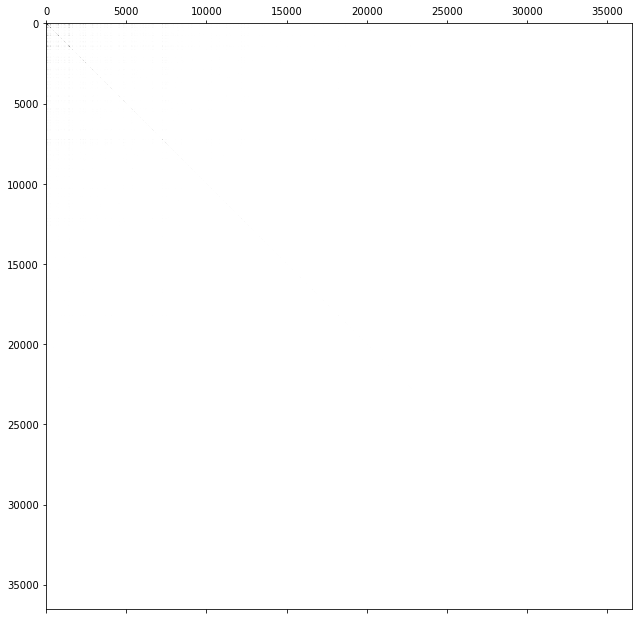

In [94]:
# visualize the matrix
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [95]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):

    similarItems = coocurrance[item_id, :]
    # return indeces of most similar items in descendign order
    mostSimilar = np.argsort(similarItems)[::-1]
    # remove the first element, as it is the item itslef
    mostSimilar = mostSimilar[1:ntop+1]
    
    # return a numpy array with the index (first column) and the value (second column) of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [96]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):

    # List similar items and its value
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    
    # Group by id and take the maximum frquency to remove duplicates
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    # sort by value in descending order
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    # get the top N
    out = sorted_list.values[:ntop, 0]
    return out

In [101]:
# Get users in train with their games
trainUsersGrouped = train.groupby('user_id')['item_id'].apply(list).reset_index()
trainUsersGrouped.head()

,user_id,item_id
0,0,"[276, 308, 192, 300, 100, 6, 391, 388, 287, 10..."
1,1,"[513, 411, 258, 650, 615, 294, 202, 77, 171, 6..."
2,2,"[791, 751, 360, 795, 629, 799, 763, 758, 725, ..."
3,3,"[823, 409, 157, 5, 369, 843, 591, 876, 877, 84..."
4,4,"[375, 903, 941, 939, 227, 957, 232, 947, 148, ..."


In [104]:
Ntop = 10
# Get the recommendations for all users 
predictions = trainUsersGrouped.item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, Ntop))
predictions.head()

KeyboardInterrupt: 

In [ ]:
# Get users in test with their movies
testUsersGrouped = test.groupby('user_id')['item_id'].apply(list).reset_index()
testUsersGrouped.head()

In [ ]:
for (seen, recom) in zip(testUsersGrouped.values[:5, 1], predictions[:5]):
    print("*"*6)
    print("Seen items: ")
    print([resample_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([resample_item_dict[i] for i in recom]) 

In [ ]:
topN=10
# Add a prediction column to train
trainUsersGrouped['prediction'] = trainUsersGrouped.item_id.apply(
    lambda x: co_occurrance_recommendation(x, coMatrix, topN)
)

In [ ]:
trainUsersGrouped.head()

In [ ]:
# Join the df with train and predictions with the test df
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id', suffixes=('_train', '_test'))

In [ ]:
joined.head()

In [ ]:
def evaluate_recall(topN, trainGrouped, testGrouped, coMatrix, popularity_baseline):
    # Add a prediction column to train
    trainUsersGrouped['prediction'] = trainUsersGrouped.item_id.apply(
        lambda x: co_occurrance_recommendation(x, coMatrix, topN))
    
    # Join with test data
    joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id', suffixes=('_train', '_test'))
    
    # Calculate average recall
    recall = joined.apply(lambda l: 
                 recall_at_n(N=topN, test=l[3], recommended=l[2], train=l[1]), axis=1).mean()
    print("Co-occurance model: recall@%s=%.3f"%(topN, recall))
    
    # Calculate average recall for the baseline
    recall_bl = joined.apply(lambda l: 
                 recall_at_n(N=topN, test=l[3], recommended=popularity_baseline, train=l[1]), axis=1).mean()
    print("Popularity model: recall%s=%.3f"%(topN, recall_bl))    
    return recall, recall_baseline

In [ ]:
for k in [5,10,20,30]:
    evaluate_recall(k, trainUsersGrouped, testUsersGrouped, coMatrix, popularbg[:, 0]);

Although the metrics reflect values of this algorithm better than those of popularity, the recommendations made by this algorithm show a certain bias towards popularity, therefore, these results will not be taken into account in the final implementation.

<a id="als"></a>

- ### Alternating Least Square (ALS) 

ALS recommender is a matrix factorization algorithm that uses Alternating Least Squares with Weighted-Lamda-Regularization (ALS-WR). It factors the user to item matrix A into the user-to-feature matrix U and the item-to-feature matrix M: It runs the ALS algorithm in a parallel fashion. The ALS algorithm should uncover the latent factors that explain the observed user to item ratings and tries to find optimal factor weights to minimize the least squares between predicted and actual ratings.

In [59]:
#Create a spark session
spark = SparkSession.builder.getOrCreate()

In [60]:
#Load data

schema = StructType(
    (
        StructField("user_id", IntegerType()),
        StructField("item_id", IntegerType()),
        StructField("rating", IntegerType()),
    )
)

df_ratings = spark.createDataFrame(dfratings, schema=schema)
df_ratings.show(5)

schema = StructType(
    (
        StructField("item_id", IntegerType()),
        StructField("title", StringType()),
        StructField("category", StringType()),
    )
)


df_games = spark.createDataFrame(dfgames, schema=schema)
df_games.show(5, False)


+-------+-------+------+
|user_id|item_id|rating|
+-------+-------+------+
|      0|      0|     0|
|      0|      1|     1|
|      0|      2|     1|
|      0|      3|     1|
|      0|      4|     1|
+-------+-------+------+
only showing top 5 rows

+-------+------------------+--------------+
|item_id|title             |category      |
+-------+------------------+--------------+
|747    |Die Macher        |1021,1026,1001|
|5896   |Dragonmaster      |1002,1010     |
|292    |Samurai           |1009,1035     |
|6308   |Tal der Könige    |1050          |
|15364  |Mare Mediterraneum|1015,1008     |
+-------+------------------+--------------+
only showing top 5 rows



In [61]:
# Count the total number of ratings in the dataset
numerator = df_ratings.select("rating").count()

# Count the number of distinct user_id and distinct item_id
num_users = df_ratings.select("user_id").distinct().count()
num_movies = df_ratings.select("item_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.19% empty.


In [62]:
#Split the data using the Spark random 
# Create test and train set
train, test = df_ratings.randomSplit([0.8, 0.2])
print ("N train: ", train.cache().count())
print ("N test: ", test.cache().count())

N train:  671793
N test:  166984


In [63]:
# Create ALS model

als = ALS(maxIter=10, regParam=0.01, implicitPrefs=True, userCol='user_id', itemCol='item_id', ratingCol='rating', nonnegative=True, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

In [64]:
# Train the model
model = als.fit(train)

In [65]:

#model.write().overwrite().save("DATA/cfModel_bm")

In [66]:
# See the predictions
predictions = model.transform(test)
predictions.show(10)

+-------+-------+------+-----------+
|user_id|item_id|rating| prediction|
+-------+-------+------+-----------+
|   1460|    148|     0|  0.3655868|
|    516|    148|     1| 0.11280986|
|   1270|    148|     1| 0.35469276|
|   2025|    148|     0|    0.31208|
|   1888|    148|     1| 0.29910618|
|   1016|    148|     0| 0.21956624|
|    857|    148|     1| 0.19321096|
|   1160|    148|     1| 0.56214905|
|   2625|    148|     0|0.116204806|
|   1417|    148|     1| 0.34382904|
+-------+-------+------+-----------+
only showing top 10 rows



In [67]:
# Pick a user and rank the predictions

user = 19

predictions.filter(F.col('user_id') == user)\
                 .orderBy(F.col('item_id')).show(5)  

predictions.filter(F.col('user_id') == user)\
                 .orderBy(F.col('prediction'), ascending=False).show(5)

+-------+-------+------+-----------+
|user_id|item_id|rating| prediction|
+-------+-------+------+-----------+
|     19|     46|     1|  0.9282619|
|     19|     63|     1| 0.49791294|
|     19|     89|     1|   0.624043|
|     19|    178|     1|0.029703587|
|     19|    268|     1|   0.600849|
+-------+-------+------+-----------+
only showing top 5 rows

+-------+-------+------+----------+
|user_id|item_id|rating|prediction|
+-------+-------+------+----------+
|     19|     46|     1| 0.9282619|
|     19|    360|     1|0.81486666|
|     19|    611|     1| 0.7101579|
|     19|    813|     1| 0.6847224|
|     19|     89|     1|  0.624043|
+-------+-------+------+----------+
only showing top 5 rows



In [68]:
# Evaluation
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [69]:
# Account for the error
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6023084582985888


In [70]:
# Make predictions and evaluate Recall and MAP

predictions_mod=predictions.select(['user_id','item_id','prediction'])

In [71]:
TOP_K = 10
rank_eval = SparkRankingEvaluation(test, predictions_mod, k = TOP_K, col_user="user_id", col_item="item_id", 
                                    col_rating="rating", col_prediction="prediction", 
                                    relevancy_method="top_k")

In [72]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

Model:	ALS
Top K:	10
MAP:	0.359592
Recall@K:	0.359592


In [73]:
# Make a recommendation

# Top 5 games for all users
userRecs = model.recommendForAllUsers(5)

# Filter for our specific user
userRecs.filter(F.col('user_id')==user).show(1,False)

+-------+-----------------------------------------------------------------------------------------+
|user_id|recommendations                                                                          |
+-------+-----------------------------------------------------------------------------------------+
|19     |[{814, 0.9360252}, {46, 0.9282619}, {4, 0.88774264}, {72, 0.88631374}, {267, 0.87691855}]|
+-------+-----------------------------------------------------------------------------------------+



#### Create the final dataset for streamlit implementation

In [74]:
#Predictions with filter by rating=1
dataSet = df_ratings.select('user_id','item_id','rating').distinct()

In [75]:
gamelookfor = df_ratings.filter(df_ratings.rating == 1).select('item_id','user_id','rating')

In [76]:
predictions_r = model.transform(dataSet.subtract(gamelookfor)).orderBy('prediction', ascending=False).toPandas()

In [77]:
# Obtain the first highest predictions for each item
bgp=predictions_r.groupby(('item_id'), as_index=False).first()
bgp.head()

,item_id,user_id,rating,prediction
0,0,2239,1,1.222818
1,1,2086,1,0.269669
2,2,2779,1,0.383809
3,3,1253,1,0.524105
4,4,1398,1,1.212433


In [78]:
# Generate n Recommendations for all users
userRecs = model.recommendForAllUsers(10)

In [79]:
nrecommendations = userRecs\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.item_id"), col("rec_exp.rating"))

In [80]:
nrecommendations.show()

+-------+-------+----------+
|user_id|item_id|    rating|
+-------+-------+----------+
|   1580|    599|0.90879816|
|   1580|    826| 0.8132607|
|   1580|    199|0.79916114|
|   1580|    435| 0.7816569|
|   1580|    280| 0.7786745|
|   1580|    155| 0.7778567|
|   1580|    576|0.76244956|
|   1580|    469|  0.740762|
|   1580|    679|0.71743363|
|   1580|    695|0.71180385|
|    471|    621|0.80431896|
|    471|     15|0.78793114|
|    471|    242| 0.7716252|
|    471|     63| 0.7691932|
|    471|    256| 0.7444445|
|    471|     51|0.73077464|
|    471|      5|0.71847504|
|    471|    268| 0.7126833|
|    471|    695| 0.6989596|
|    471|    303|0.66659886|
+-------+-------+----------+
only showing top 20 rows



In [81]:
# Join with the df_games
nrecus=nrecommendations.join(df_games, on='item_id').toPandas()

In [82]:
nrecus.head()

,item_id,user_id,rating,title,category
0,148,1088,0.984530,Hanabi,"1002,1039,1045"
1,148,2659,0.757321,Hanabi,"1002,1039,1045"
2,148,1395,0.624482,Hanabi,"1002,1039,1045"
3,148,897,0.297933,Hanabi,"1002,1039,1045"
4,148,1127,0.748979,Hanabi,"1002,1039,1045"


In [83]:
# Groupby user_id and show the recommendations

nrecusgby = (nrecus.groupby('user_id')['title'].apply(list).reset_index())
nrecusgby.head()

,user_id,title
0,0,"[Lost Cities, Bohnanza, For Sale, Agricola, Co..."
1,1,"[Lost Cities, No Thanks!, For Sale, Coloretto,..."
2,2,"[Hanabi, Coup, Dominion, Race for the Galaxy, ..."
3,3,"[Bohnanza, Dominion, 7 Wonders, Race for the G..."
4,4,"[No Thanks!, 7 Wonders Duel, Kingdomino, Just ..."


In [84]:
# Join with the dF first highest predictions
sim_rec = pd.merge(bgp[['item_id','user_id']], nrecusgby, how='left', left_on=['user_id'], right_on=['user_id'])

In [85]:
sim_rec.head()

,item_id,user_id,title
0,0,2239,"[Antiquity, Indonesia, Twilight Struggle, Chic..."
1,1,2086,"[Guillotine, Civilization, RoboRally, Clue, Ca..."
2,2,2779,"[Hanabi, Race for the Galaxy, Twilight Struggl..."
3,3,1253,"[The Princes of Florence, Hoity Toity, Medici,..."
4,4,1398,"[Pickomino, Stone Age, Lost Cities, Bohnanza, ..."


In [86]:
dfgames.head()

,item_id,title,category
0,747,Die Macher,"1021,1026,1001"
1,5896,Dragonmaster,"1002,1010"
2,292,Samurai,"1009,1035"
3,6308,Tal der Könige,1050
4,15364,Mare Mediterraneum,"1015,1008"


In [87]:
# Add the Game board title
sim_rec2 = pd.merge(sim_rec[['item_id','title']], dfgames[['item_id', 'title']], how='left', left_on=['item_id'], right_on=['item_id'])

In [88]:
simrec = pd.DataFrame()

simrec['item_id']=sim_rec2['item_id']
simrec['title']=sim_rec2['title_y']
simrec['recommendation']=sim_rec2['title_x']

In [89]:
simrec.head()

,item_id,title,recommendation
0,0,1830: Railways & Robber Barons,"[Antiquity, Indonesia, Twilight Struggle, Chic..."
1,1,18AL,"[Guillotine, Civilization, RoboRally, Clue, Ca..."
2,2,2 de Mayo,"[Hanabi, Race for the Galaxy, Twilight Struggl..."
3,3,23,"[The Princes of Florence, Hoity Toity, Medici,..."
4,4,6 nimmt!,"[Pickomino, Stone Age, Lost Cities, Bohnanza, ..."


In [90]:
simrec.set_index('title', inplace = True)
simrec.head()

,item_id,recommendation
title,,
1830: Railways & Robber Barons,0,"[Antiquity, Indonesia, Twilight Struggle, Chic..."
18AL,1,"[Guillotine, Civilization, RoboRally, Clue, Ca..."
2 de Mayo,2,"[Hanabi, Race for the Galaxy, Twilight Struggl..."
23,3,"[The Princes of Florence, Hoity Toity, Medici,..."
6 nimmt!,4,"[Pickomino, Stone Age, Lost Cities, Bohnanza, ..."


In [91]:
#simrec.to_csv("DATA/cf_similars.csv")